# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

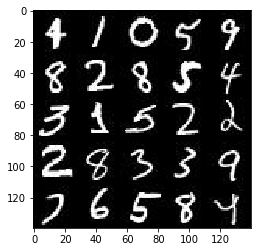

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

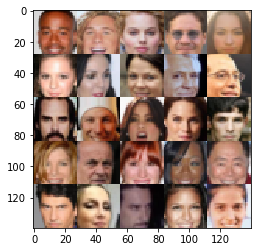

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_inputs = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, shape=())
    return inputs, z_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [65]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    keep_prob = 0.9
    with tf.variable_scope('discriminator', reuse=reuse):
         # Input layer is 28x28xchannels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        x1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob)
        # 7x7x128
        
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob)
        # 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [64]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.9
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob)
        # 14x14x128 
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 2, strides=2, padding='same', activation=None)
        # 28x28xout_channel_dim now
        
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    gen = generator(input_z, out_channel_dim)
    model_real, logits_real = discriminator(input_real)
    model_gen, logits_gen = discriminator(gen, reuse=True)
    
    dloss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(model_real) * (1-smooth)))
    dloss_gen = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_gen, labels=tf.zeros_like(model_gen)))
    gloss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_gen, labels=tf.ones_like(model_gen)))
    dloss = dloss_real + dloss_gen
    
    return dloss, gloss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get trainable variables
    trainable = tf.trainable_variables()
    d_trainable = [var for var in trainable if var.name.startswith('discriminator')]
    g_trainable = [var for var in trainable if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_trainable)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_trainable)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    inputs, zinputs, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    dloss, gloss = model_loss(inputs, zinputs, data_shape[3])
    dtrain, gtrain = model_opt(dloss, gloss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(dtrain, feed_dict={inputs:batch_images, zinputs: batch_z, lr:learning_rate})
                
                # Train generator twice
                _ = sess.run(gtrain, feed_dict={inputs:batch_images, zinputs: batch_z, lr:learning_rate})
                _ = sess.run(gtrain, feed_dict={inputs:batch_images, zinputs: batch_z, lr:learning_rate})
                if steps == 1:
                    show_generator_output(sess, 36, zinputs, data_shape[3], data_image_mode)
                    
                if steps % 10 == 0:
                    dloss_value = dloss.eval({inputs:batch_images, zinputs: batch_z})
                    gloss_value = gloss.eval({zinputs: batch_z})
                    print("Step {}...".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(dloss_value),
                          "Generator Loss: {:.4f}".format(gloss_value))
                    
                if steps % 100 == 0:
                    can_show = True
                    show_generator_output(sess, 36, zinputs, data_shape[3], data_image_mode)
                    
        # Show at the end
        show_generator_output(sess, 36, zinputs, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

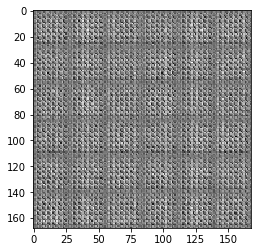

Step 10... Epoch 1/2... Discriminator Loss: 1.5421... Generator Loss: 0.5359
Step 20... Epoch 1/2... Discriminator Loss: 1.5343... Generator Loss: 1.1891
Step 30... Epoch 1/2... Discriminator Loss: 1.8061... Generator Loss: 0.8501
Step 40... Epoch 1/2... Discriminator Loss: 1.9737... Generator Loss: 0.3595
Step 50... Epoch 1/2... Discriminator Loss: 1.7582... Generator Loss: 0.3908
Step 60... Epoch 1/2... Discriminator Loss: 1.7770... Generator Loss: 0.3634
Step 70... Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 1.0414
Step 80... Epoch 1/2... Discriminator Loss: 1.2481... Generator Loss: 0.7241
Step 90... Epoch 1/2... Discriminator Loss: 1.3174... Generator Loss: 0.6072
Step 100... Epoch 1/2... Discriminator Loss: 1.1396... Generator Loss: 0.7659


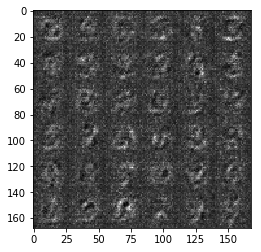

Step 110... Epoch 1/2... Discriminator Loss: 1.6050... Generator Loss: 3.3325
Step 120... Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 2.4706
Step 130... Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 3.1388
Step 140... Epoch 1/2... Discriminator Loss: 1.2676... Generator Loss: 3.9692
Step 150... Epoch 1/2... Discriminator Loss: 0.6977... Generator Loss: 3.5099
Step 160... Epoch 1/2... Discriminator Loss: 0.7182... Generator Loss: 1.6360
Step 170... Epoch 1/2... Discriminator Loss: 0.9785... Generator Loss: 0.9528
Step 180... Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 3.4089
Step 190... Epoch 1/2... Discriminator Loss: 0.9809... Generator Loss: 0.9490
Step 200... Epoch 1/2... Discriminator Loss: 0.8471... Generator Loss: 1.5525


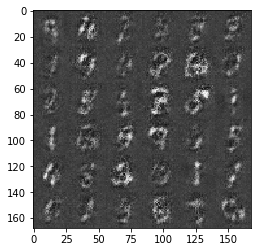

Step 210... Epoch 1/2... Discriminator Loss: 0.8489... Generator Loss: 2.3319
Step 220... Epoch 1/2... Discriminator Loss: 0.9874... Generator Loss: 0.8825
Step 230... Epoch 1/2... Discriminator Loss: 0.8448... Generator Loss: 1.2288
Step 240... Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 1.8521
Step 250... Epoch 1/2... Discriminator Loss: 1.0432... Generator Loss: 2.3981
Step 260... Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 2.2712
Step 270... Epoch 1/2... Discriminator Loss: 0.8097... Generator Loss: 1.5121
Step 280... Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 1.3599
Step 290... Epoch 1/2... Discriminator Loss: 0.9434... Generator Loss: 0.9304
Step 300... Epoch 1/2... Discriminator Loss: 1.3350... Generator Loss: 0.5102


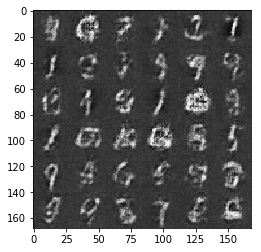

Step 310... Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.5555
Step 320... Epoch 1/2... Discriminator Loss: 1.0901... Generator Loss: 0.7957
Step 330... Epoch 1/2... Discriminator Loss: 1.4352... Generator Loss: 3.5636
Step 340... Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 2.9042
Step 350... Epoch 1/2... Discriminator Loss: 0.9911... Generator Loss: 1.9241
Step 360... Epoch 1/2... Discriminator Loss: 0.8496... Generator Loss: 1.3144
Step 370... Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 0.6008
Step 380... Epoch 1/2... Discriminator Loss: 1.0200... Generator Loss: 0.8408
Step 390... Epoch 1/2... Discriminator Loss: 1.1057... Generator Loss: 0.7764
Step 400... Epoch 1/2... Discriminator Loss: 0.9503... Generator Loss: 0.9467


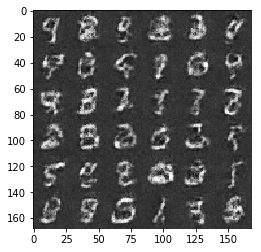

Step 410... Epoch 1/2... Discriminator Loss: 0.8705... Generator Loss: 1.1169
Step 420... Epoch 1/2... Discriminator Loss: 1.7088... Generator Loss: 0.3507
Step 430... Epoch 1/2... Discriminator Loss: 0.9305... Generator Loss: 2.1932
Step 440... Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 2.1019
Step 450... Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 2.2227
Step 460... Epoch 1/2... Discriminator Loss: 1.1484... Generator Loss: 0.6709


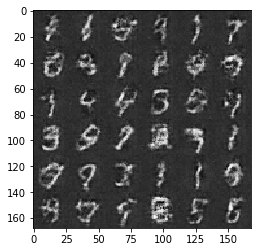

Step 10... Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 0.7056
Step 20... Epoch 2/2... Discriminator Loss: 1.5047... Generator Loss: 0.5076
Step 30... Epoch 2/2... Discriminator Loss: 0.8376... Generator Loss: 1.2543
Step 40... Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.7732
Step 50... Epoch 2/2... Discriminator Loss: 1.6374... Generator Loss: 0.3679
Step 60... Epoch 2/2... Discriminator Loss: 0.8007... Generator Loss: 1.5288
Step 70... Epoch 2/2... Discriminator Loss: 0.7548... Generator Loss: 1.8704
Step 80... Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 0.9616
Step 90... Epoch 2/2... Discriminator Loss: 0.9048... Generator Loss: 2.6903
Step 100... Epoch 2/2... Discriminator Loss: 0.9975... Generator Loss: 0.8786


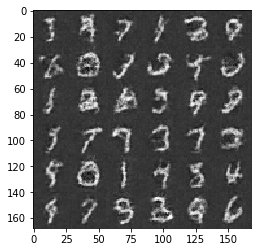

Step 110... Epoch 2/2... Discriminator Loss: 0.9938... Generator Loss: 0.8213
Step 120... Epoch 2/2... Discriminator Loss: 0.8025... Generator Loss: 1.1066
Step 130... Epoch 2/2... Discriminator Loss: 1.1416... Generator Loss: 3.0463
Step 140... Epoch 2/2... Discriminator Loss: 1.1175... Generator Loss: 1.0414
Step 150... Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.2998
Step 160... Epoch 2/2... Discriminator Loss: 0.7170... Generator Loss: 1.6646
Step 170... Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 1.4186
Step 180... Epoch 2/2... Discriminator Loss: 0.6856... Generator Loss: 1.7984
Step 190... Epoch 2/2... Discriminator Loss: 0.8746... Generator Loss: 1.0898
Step 200... Epoch 2/2... Discriminator Loss: 0.8388... Generator Loss: 1.0544


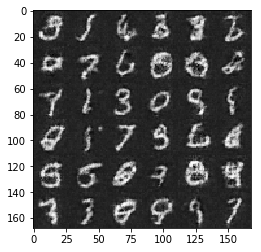

Step 210... Epoch 2/2... Discriminator Loss: 0.8299... Generator Loss: 1.1113
Step 220... Epoch 2/2... Discriminator Loss: 0.6242... Generator Loss: 2.1146
Step 230... Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 2.0264
Step 240... Epoch 2/2... Discriminator Loss: 0.9222... Generator Loss: 1.1149
Step 250... Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 0.9625
Step 260... Epoch 2/2... Discriminator Loss: 0.6353... Generator Loss: 2.0908
Step 270... Epoch 2/2... Discriminator Loss: 0.6915... Generator Loss: 1.5883
Step 280... Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 1.7339
Step 290... Epoch 2/2... Discriminator Loss: 0.5924... Generator Loss: 1.7952
Step 300... Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 2.4203


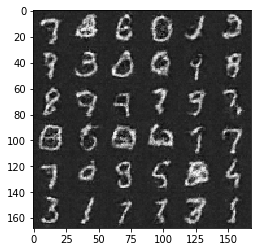

Step 310... Epoch 2/2... Discriminator Loss: 0.5489... Generator Loss: 2.1439
Step 320... Epoch 2/2... Discriminator Loss: 3.0084... Generator Loss: 0.1033
Step 330... Epoch 2/2... Discriminator Loss: 0.8279... Generator Loss: 1.3215
Step 340... Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 1.3738
Step 350... Epoch 2/2... Discriminator Loss: 0.6139... Generator Loss: 1.8848
Step 360... Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 1.2665
Step 370... Epoch 2/2... Discriminator Loss: 0.5649... Generator Loss: 2.0091
Step 380... Epoch 2/2... Discriminator Loss: 0.5379... Generator Loss: 1.9827
Step 390... Epoch 2/2... Discriminator Loss: 0.5519... Generator Loss: 2.0122
Step 400... Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 1.4892


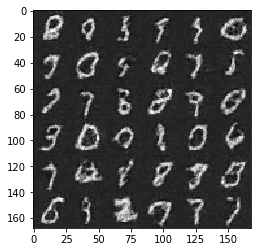

Step 410... Epoch 2/2... Discriminator Loss: 0.5138... Generator Loss: 2.8803
Step 420... Epoch 2/2... Discriminator Loss: 1.6008... Generator Loss: 2.1007
Step 430... Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 1.2590
Step 440... Epoch 2/2... Discriminator Loss: 0.6761... Generator Loss: 1.7435
Step 450... Epoch 2/2... Discriminator Loss: 0.5688... Generator Loss: 2.0646
Step 460... Epoch 2/2... Discriminator Loss: 0.5804... Generator Loss: 2.3461


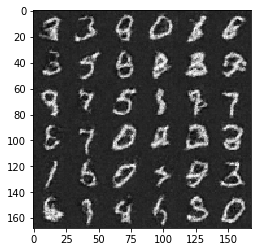

In [66]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

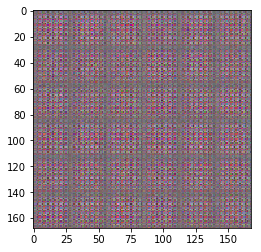

Step 10... Epoch 1/1... Discriminator Loss: 5.0371... Generator Loss: 0.1747
Step 20... Epoch 1/1... Discriminator Loss: 2.9167... Generator Loss: 0.1803
Step 30... Epoch 1/1... Discriminator Loss: 2.2475... Generator Loss: 0.3388
Step 40... Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 1.1831
Step 50... Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.4959
Step 60... Epoch 1/1... Discriminator Loss: 0.8481... Generator Loss: 1.1257
Step 70... Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 1.7574
Step 80... Epoch 1/1... Discriminator Loss: 0.7600... Generator Loss: 1.5982
Step 90... Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 4.0984
Step 100... Epoch 1/1... Discriminator Loss: 2.3374... Generator Loss: 0.2644


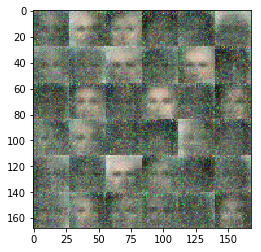

Step 110... Epoch 1/1... Discriminator Loss: 1.5898... Generator Loss: 0.4443
Step 120... Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 2.0242
Step 130... Epoch 1/1... Discriminator Loss: 1.7508... Generator Loss: 0.5576
Step 140... Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 2.0756
Step 150... Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.3610
Step 160... Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 2.0907
Step 170... Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 1.4517
Step 180... Epoch 1/1... Discriminator Loss: 1.7083... Generator Loss: 0.5524
Step 190... Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.6598
Step 200... Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.9447


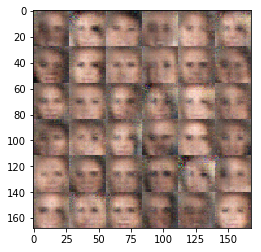

Step 210... Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7849
Step 220... Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6600
Step 230... Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7604
Step 240... Epoch 1/1... Discriminator Loss: 1.6557... Generator Loss: 0.5702
Step 250... Epoch 1/1... Discriminator Loss: 1.6983... Generator Loss: 0.6413
Step 260... Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.5661
Step 270... Epoch 1/1... Discriminator Loss: 1.8519... Generator Loss: 0.4591
Step 280... Epoch 1/1... Discriminator Loss: 1.9357... Generator Loss: 0.6915
Step 290... Epoch 1/1... Discriminator Loss: 1.6018... Generator Loss: 0.6708
Step 300... Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7185


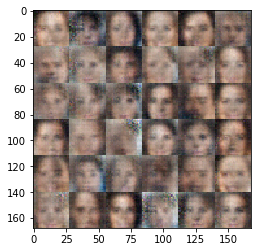

Step 310... Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.9860
Step 320... Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.7032
Step 330... Epoch 1/1... Discriminator Loss: 1.6985... Generator Loss: 0.7602
Step 340... Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.7234
Step 350... Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.6719
Step 360... Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.7041
Step 370... Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.7282
Step 380... Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.7411
Step 390... Epoch 1/1... Discriminator Loss: 1.7065... Generator Loss: 0.7833
Step 400... Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.7402


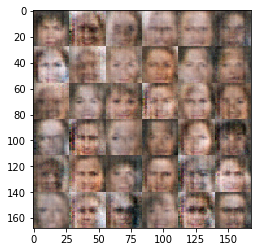

Step 410... Epoch 1/1... Discriminator Loss: 1.5618... Generator Loss: 0.6915
Step 420... Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.8800
Step 430... Epoch 1/1... Discriminator Loss: 1.6693... Generator Loss: 0.6380
Step 440... Epoch 1/1... Discriminator Loss: 1.6523... Generator Loss: 0.6949
Step 450... Epoch 1/1... Discriminator Loss: 1.5641... Generator Loss: 0.6947
Step 460... Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.6962
Step 470... Epoch 1/1... Discriminator Loss: 1.6613... Generator Loss: 0.7299
Step 480... Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.7513
Step 490... Epoch 1/1... Discriminator Loss: 1.4800... Generator Loss: 0.8283
Step 500... Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.7633


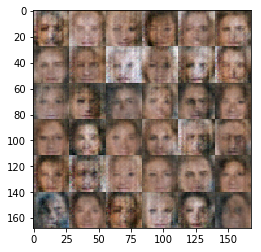

Step 510... Epoch 1/1... Discriminator Loss: 1.5408... Generator Loss: 0.6787
Step 520... Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.8399
Step 530... Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.7129
Step 540... Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7369
Step 550... Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 0.6750
Step 560... Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.7583
Step 570... Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.7250
Step 580... Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7926
Step 590... Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.6522
Step 600... Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.7292


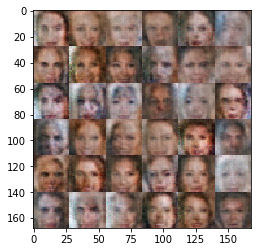

Step 610... Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6669
Step 620... Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.7482
Step 630... Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.6464
Step 640... Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.7286
Step 650... Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7930
Step 660... Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7828
Step 670... Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.7171
Step 680... Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7418
Step 690... Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.8113
Step 700... Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.7953


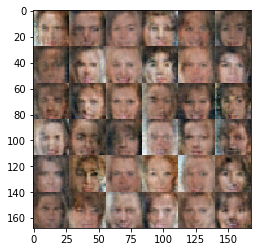

Step 710... Epoch 1/1... Discriminator Loss: 1.5624... Generator Loss: 0.6982
Step 720... Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.7658
Step 730... Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6958
Step 740... Epoch 1/1... Discriminator Loss: 1.5175... Generator Loss: 0.7989
Step 750... Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7634
Step 760... Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.7879
Step 770... Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.7875
Step 780... Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.8177
Step 790... Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.7547
Step 800... Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.8498


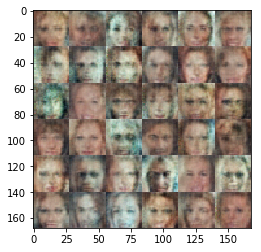

Step 810... Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7867
Step 820... Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7878
Step 830... Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.7974
Step 840... Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.8006
Step 850... Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7126
Step 860... Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.7684
Step 870... Epoch 1/1... Discriminator Loss: 1.5142... Generator Loss: 0.7254
Step 880... Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.6897
Step 890... Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.8738
Step 900... Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.7594


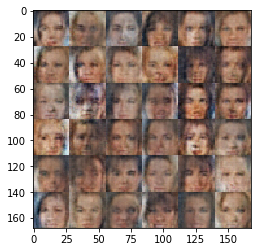

Step 910... Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7790
Step 920... Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8467
Step 930... Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.7985
Step 940... Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7633
Step 950... Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.8029
Step 960... Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7203
Step 970... Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7663
Step 980... Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.7514
Step 990... Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7495
Step 1000... Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7846


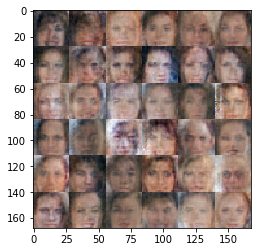

Step 1010... Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7756
Step 1020... Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.7019
Step 1030... Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.8222
Step 1040... Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7927
Step 1050... Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7316
Step 1060... Epoch 1/1... Discriminator Loss: 1.4911... Generator Loss: 0.7360
Step 1070... Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.7089
Step 1080... Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7837
Step 1090... Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7750
Step 1100... Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.7684


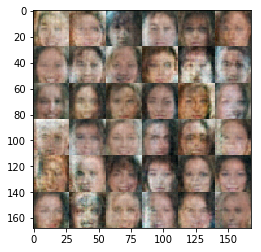

Step 1110... Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7507
Step 1120... Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8181
Step 1130... Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.7018
Step 1140... Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8000
Step 1150... Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.7493
Step 1160... Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.7791
Step 1170... Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7372
Step 1180... Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7608
Step 1190... Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.8147
Step 1200... Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.7854


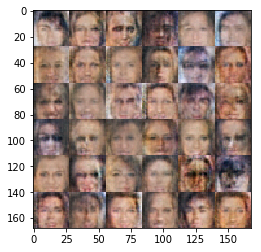

Step 1210... Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7434
Step 1220... Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.8537
Step 1230... Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7055
Step 1240... Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7658
Step 1250... Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.7325
Step 1260... Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.8263
Step 1270... Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.7265
Step 1280... Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7456
Step 1290... Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7697
Step 1300... Epoch 1/1... Discriminator Loss: 1.5076... Generator Loss: 0.6884


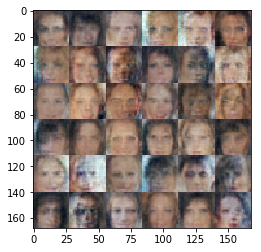

Step 1310... Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7513
Step 1320... Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.8619
Step 1330... Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7972
Step 1340... Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7628
Step 1350... Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.8024
Step 1360... Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7800
Step 1370... Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.7803
Step 1380... Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.7265
Step 1390... Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7613
Step 1400... Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7771


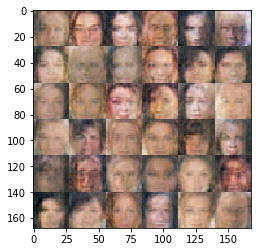

Step 1410... Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7914
Step 1420... Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.6854
Step 1430... Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.7371
Step 1440... Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.7965
Step 1450... Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 0.7464
Step 1460... Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7607
Step 1470... Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.8077
Step 1480... Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.7245
Step 1490... Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8146
Step 1500... Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7500


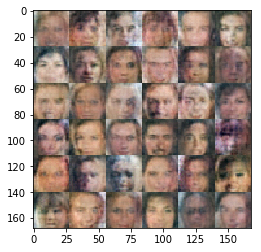

Step 1510... Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.7532
Step 1520... Epoch 1/1... Discriminator Loss: 1.4597... Generator Loss: 0.7351
Step 1530... Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7757
Step 1540... Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8257
Step 1550... Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7223
Step 1560... Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7788
Step 1570... Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.8442
Step 1580... Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.8475
Step 1590... Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7086
Step 1600... Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8284


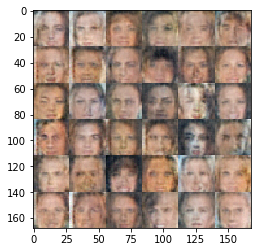

Step 1610... Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.7275
Step 1620... Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.8138
Step 1630... Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7783
Step 1640... Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7734
Step 1650... Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7719
Step 1660... Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7431
Step 1670... Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7878
Step 1680... Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7155
Step 1690... Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8504
Step 1700... Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.7225


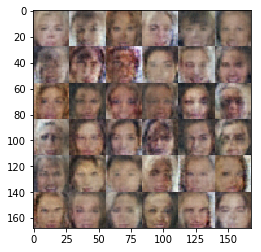

Step 1710... Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8298
Step 1720... Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7936
Step 1730... Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7629
Step 1740... Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7725
Step 1750... Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.7779
Step 1760... Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7797
Step 1770... Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7870
Step 1780... Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8162
Step 1790... Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.9060
Step 1800... Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7543


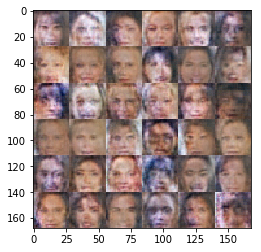

Step 1810... Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8598
Step 1820... Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.8036
Step 1830... Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7941
Step 1840... Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6920
Step 1850... Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.7560
Step 1860... Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.8286
Step 1870... Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7655
Step 1880... Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7465
Step 1890... Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.7879
Step 1900... Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.7597


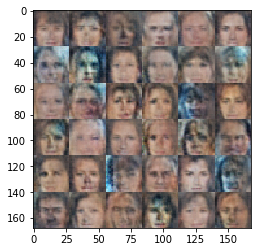

Step 1910... Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.7094
Step 1920... Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8143
Step 1930... Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7611
Step 1940... Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7049
Step 1950... Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7113
Step 1960... Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7220
Step 1970... Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7084
Step 1980... Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.6292
Step 1990... Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7647
Step 2000... Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7883


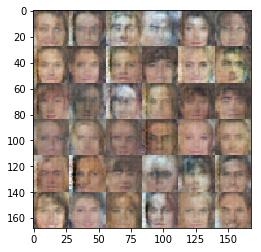

Step 2010... Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7632
Step 2020... Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.8461
Step 2030... Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6724
Step 2040... Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7719
Step 2050... Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7953
Step 2060... Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7223
Step 2070... Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7514
Step 2080... Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7902
Step 2090... Epoch 1/1... Discriminator Loss: 1.4337... Generator Loss: 0.7223
Step 2100... Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7615


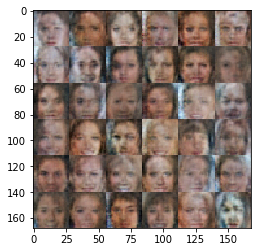

Step 2110... Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8150
Step 2120... Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7172
Step 2130... Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.7584
Step 2140... Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7651
Step 2150... Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7785
Step 2160... Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7666
Step 2170... Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6794
Step 2180... Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.8247
Step 2190... Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7363
Step 2200... Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7967


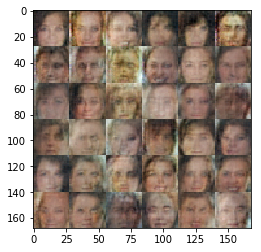

Step 2210... Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.7804
Step 2220... Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.7249
Step 2230... Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7326
Step 2240... Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.8021
Step 2250... Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7217
Step 2260... Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.8218
Step 2270... Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.8470
Step 2280... Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7475
Step 2290... Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7893
Step 2300... Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7901


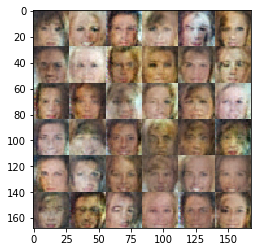

Step 2310... Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.8005
Step 2320... Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8221
Step 2330... Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 1.0299
Step 2340... Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.8058
Step 2350... Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.8239
Step 2360... Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.7714
Step 2370... Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7325
Step 2380... Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7563
Step 2390... Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.9053
Step 2400... Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7982


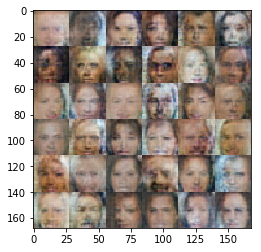

Step 2410... Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7569
Step 2420... Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.7378
Step 2430... Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7224
Step 2440... Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7219
Step 2450... Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7491
Step 2460... Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7932
Step 2470... Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.7254
Step 2480... Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.8660
Step 2490... Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8504
Step 2500... Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7601


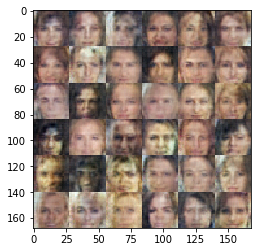

Step 2510... Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.8351
Step 2520... Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.8270
Step 2530... Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6900
Step 2540... Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.9805
Step 2550... Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.7712
Step 2560... Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7649
Step 2570... Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7818
Step 2580... Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7471
Step 2590... Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.6900
Step 2600... Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.9349


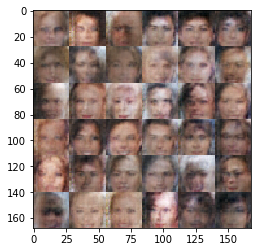

Step 2610... Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7577
Step 2620... Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7557
Step 2630... Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7596
Step 2640... Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 1.0154
Step 2650... Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7763
Step 2660... Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.9651
Step 2670... Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7654
Step 2680... Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7295
Step 2690... Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7989
Step 2700... Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6721


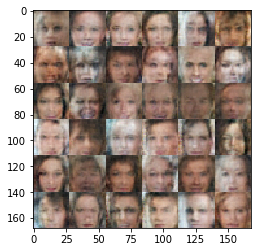

Step 2710... Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8181
Step 2720... Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7857
Step 2730... Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.8123
Step 2740... Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6913
Step 2750... Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7636
Step 2760... Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6970
Step 2770... Epoch 1/1... Discriminator Loss: 1.4692... Generator Loss: 0.7140
Step 2780... Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.8246
Step 2790... Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7567
Step 2800... Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.6734


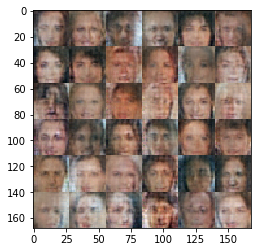

Step 2810... Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7864
Step 2820... Epoch 1/1... Discriminator Loss: 1.4887... Generator Loss: 0.7106
Step 2830... Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6835
Step 2840... Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7637
Step 2850... Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.9098
Step 2860... Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.6428
Step 2870... Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7133
Step 2880... Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.8312
Step 2890... Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7651
Step 2900... Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7466


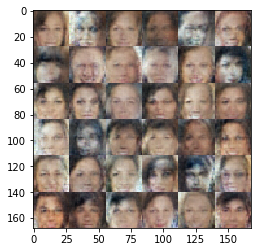

Step 2910... Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7985
Step 2920... Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7671
Step 2930... Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7414
Step 2940... Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7003
Step 2950... Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7389
Step 2960... Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6420
Step 2970... Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.8857
Step 2980... Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8145
Step 2990... Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7756
Step 3000... Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.6712


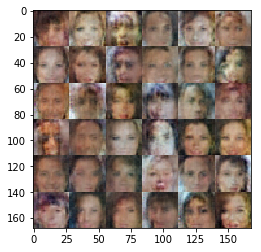

Step 3010... Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.8130
Step 3020... Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.9505
Step 3030... Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.9273
Step 3040... Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.8018
Step 3050... Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.8206
Step 3060... Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7520
Step 3070... Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8575
Step 3080... Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.6279
Step 3090... Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8518
Step 3100... Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.9155


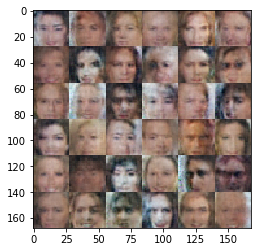

Step 3110... Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6576
Step 3120... Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 1.0842
Step 3130... Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6280
Step 3140... Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.8040
Step 3150... Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7205
Step 3160... Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7956


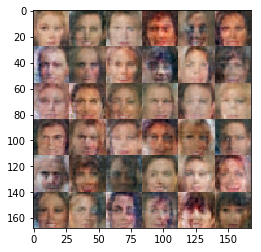

In [59]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.